In [140]:
push!(LOAD_PATH, "functions/")
using BP
using Arpack
using LinearAlgebra
using Random, Plots, SparseArrays, ITensors, Statistics, ProgressMeter, Colors
include("ldpc_tanner_loops.jl")


function parity_tensor(index_arr, parity)
    num = length(index_arr)
    tens = ITensor(index_arr)
    for i in 0:(2^num - 1)
        bits = digits(i, base=2, pad=num) 
        if sum(bits) % 2 == parity
            inds_tuple = (index_arr[j] => bits[j] + 1 for j in 1:num)
            tens[inds_tuple...] = 1.0        
        end 
    end
    return tens 
end 

function get_nbrs_of_check(adj_mat, v)
    ## get nbrs of node v from adj_mat
    row = adj_mat[v, :]
    return findall(x -> x == 1, row)
end

function get_nbrs_of_data(adj_mat, v)
    ## get nbrs of node v from adj_mat
    col = adj_mat[:, v]
    return findall(x -> x == 1, col)
end

function get_network(pcmat, syndrome, pbias)
    ## pcmat: (n-k) x (n)
    ## syndrome: (n-k)
    ## close syndrome legs with given syndrome, keeps data legs open for later
    m, n = size(pcmat)
    k = n - m 
    indmat = [Index(2, "s$(i)d$(j)") for i in 1:m, j in 1:n]
    datainds = [Index(2, "x$i") for i in 1:n]
    data_tensors = []
    syn_tensors = []

    ## data data_tensors

    for i = 1:n 
        dummy = Index(2, "biasi")
        biastensor = ITensor(2 .* [1-pbias, pbias],dummy)
        checks = get_nbrs_of_data(pcmat,i)
        indxs = [indmat[jj,i] for jj in checks]
        push!(indxs,dummy)
        push!(indxs,datainds[i])
        push!(data_tensors,(delta(indxs) * biastensor))
    end 

    ## check tensors 
    for j = 1:m
        datas = get_nbrs_of_check(pcmat,j)
        tensor = parity_tensor([indmat[j,ii] for ii in datas],syndrome[j])
        push!(syn_tensors,tensor)
    end 
    return data_tensors, syn_tensors, datainds
end 


function bit_to_onehot(x)
    if x == 0
        return [2, 0]
    elseif x == 1
        return [0, 2]
    elseif x == -1
        return [1, 1]
    else
        error("Input must be -1, 0, or 1")
    end
end


function get_marginal_data_tensors(data_tensors,data_indices,data_inputs;exclude=[])
    N = length(data_tensors)
    marginalized = []
    for i = 1 : N 
        if !(i in exclude)
            tens = data_tensors[i] *  ITensor(bit_to_onehot(data_inputs[i]),data_indices[i])
        else 
            tens = data_tensors[i]
        end 
        push!(marginalized,tens)
    end 
    return marginalized
end 


function sample_bit(p0)
    return rand() < p0 ? 0 : 1
end

function toric_code_X_parity_matrix(L::Int)
    N = 2 * L^2   # number of qubits
    M = L^2       # number of X checks (vertices)
    
    pcmat = spzeros(Int, M, N)
    
    for v in 1:M
        i = div(v-1, L) + 1  # vertex row
        j = mod1(v, L)       # vertex col
        
        # Horizontal edges (apply periodic boundary for i-1)
        h_edge1 = (mod1(i-1, L) - 1)*L + j
        h_edge2 = (mod1(i, L) - 1)*L + j
        
        # Vertical edges
        v_edge1 = L^2 + (i-1)*L + mod1(j-1, L)
        v_edge2 = L^2 + (i-1)*L + j
        
        pcmat[v, h_edge1] = 1
        pcmat[v, h_edge2] = 1
        pcmat[v, v_edge1] = 1
        pcmat[v, v_edge2] = 1
    end
    
    return pcmat
end

function toric_code_logical_operators(L::Int)
    # Compute the null space (logical operators) of the toric code parity check matrix
    pcmat = toric_code_X_parity_matrix(L)
    N = 2 * L^2
    
    # Convert to GF(2) by using mod 2 arithmetic
    # We'll manually construct the logical operators for the toric code
    
    # For a toric code of size L, there are 2 logical X and 2 logical Z operators
    # We'll return the logical Z operators (null space of X check matrix)
    
    # Create logical operators matrix (2 logical operators)
    logical_ops = zeros(Int, 2, N)
    
    # First logical operator: horizontal loop around the torus
    for i = 1:L
        logical_ops[1, (i-1)*L + 1] = 1  # First column of each row
    end
    
    # Second logical operator: vertical loop around the torus
    for j = 1:L
        logical_ops[2, L^2 + j] = 1  # First row of vertical edges
    end
    
    # Verify these are in the null space (PCM * logical_ops' = 0 mod 2)
    @assert all([(pcmat * logical_ops'[:,i]) .% 2 == zeros(L^2) for i in 1:2])
    
    return logical_ops
end


function get_marginal(tensors,adj_mat,messages,index)
    nbrs = BP.get_nbrs(adj_mat, index)
    Z_local = tensors[index] 
    for nbr in nbrs
        Z_local *= messages[nbr,index] 
    end
    return Z_local
end 

function loop_contribution(loop, messages, tensors, edges, links, adj_mat)
    # Initialize tracking variables
    vertices_done = Set()  # Track which vertices have been processed
    loop_contri = 1        # Accumulate the loop contribution tensor product
    N = length(tensors)    # Total number of vertices in tensor network
    
    # Step 1: Process each edge in the loop
    for edge in loop
        v1, v2 = edge  # v1 < v2 by convention 
        
        # Replace BP message with excited projector P⊥ = I - μ†μ
        excitation = BP.excited_edge(edge, messages, edges, links, adj_mat)
        loop_contri *= excitation
        
        # Step 2a: Process vertex v1 (if not already done)
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            
            # Find all vertices connected to v1 within the loop
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            
            # Determine which indices need priming for proper tensor contraction
            edges_with_v1 = filter(t -> v1 in t, loop)  # Find loop edges containing v1
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v1]  # Map to global edge list
            larger_bools = [v1 == max(t[1], t[2]) for t in edges_with_v1]  # v1 is larger vertex → prime needed
            selected_links = links[edge_indices[larger_bools]]  # Select indices to prime
            
            # Apply tensor T_v1 with appropriate index priming
            contri = !isempty(selected_links) ? prime(tensors[v1], selected_links...) : tensors[v1]
            loop_contri *= contri
            
            # Add BP messages from neighbors outside the loop
            for w in BP.get_nbrs(adj_mat, v1)
                current_edge = (min(v1,w), max(v1,w))  # Standard edge ordering
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]
                
                # Only add message if: (1) index exists in current contraction, (2) neighbor is outside loop
                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1]  
                end
            end
        end
        
        # Step 2b: Process vertex v2 (if not already done) - identical logic to v1
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            edges_with_v2 = filter(t -> v2 in t, loop) 
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v2]
            larger_bools = [v2 == max(t[1], t[2]) for t in edges_with_v2]
            selected_links = links[edge_indices[larger_bools]]
            contri = !isempty(selected_links) ? prime(tensors[v2], selected_links...) : tensors[v2]
            loop_contri *= contri 

            for w in BP.get_nbrs(adj_mat, v2)
                current_edge = (min(v2,w), max(v2,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]

                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2]  
                end
            end
        end
    end
    
    # Step 3: Contract to scalar and multiply by BP partition function on remaining vertices
    # Loop contribution (scalar) × BP partition function on vertices outside the loop
    return (loop_contri) #* mean_free_partition_fn(setdiff(Set(1:N), vertices_done), tensors, messages, edges, links, adj_mat)
end

function tensorargmax(probs)
    ix = inds(probs)[1]
    probs = [real((probs)[ix=>n]) for n in 1:dim(ix)]
    probs ./= sum(probs)
    return Int(argmax(probs)-1) #sample_bit(probs[1])
end 

tensorargmax (generic function with 1 method)

In [145]:
L = 7
p = 0.07
pbias = p

pcmat = toric_code_X_parity_matrix(L)
m, n = size(pcmat)
# Track errors within this batch
logical_errors = []
logical_ops = toric_code_logical_operators(L);

In [149]:
# Sample errors iid with probability p
errors_true = [sample_bit(1-p) for _ in 1:n]
# Compute syndrome
syndrome = pcmat * errors_true .% 2;

In [153]:
max_loop_order = 6
tannerloopslist = [find_tanner_loops(pcmat, d; max_length=max_loop_order) for d in 1:n]

data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome, pbias)
errors = Int.(-1 .* ones(n))
tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors), syn_tensors)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)
priors = [ITensor([0.,0.], data_indices[i]) for i in 1:n]

for d = 1:n
    
    probs = get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,d)
    tannerloops = tannerloopslist[d]
    loop_list = [tannerloop.edges for tannerloop in tannerloops] 
    data_bits_involved_list = [tannerloop.data_bits for tannerloop in tannerloops]
    check_bits_involved_list = [tannerloop.check_bits for tannerloop in tannerloops]
    vacuum = tensorargmax(probs)
    for (i, loop) in enumerate(loop_list)
        data_bits_involved = data_bits_involved_list[i] 
        check_bits_involved = check_bits_involved_list[i] 
        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; exclude=[d]), syn_tensors)
        normlz = (prod([get_marginal(mtensors,adj_mat,messages,other_data_bit) for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
        normlz *= (prod([get_marginal(mtensors,adj_mat,messages,n+check_bit) for check_bit in check_bits_involved]))
        change = loop_contribution(loop, messages, mtensors, edges, links, adj_mat) / normlz
        probs += change 
    end 

    loopcorr = tensorargmax(probs)
    error_i = loopcorr #sample_bit(probs[1])
    if vacuum != loopcorr 
        println("voo")
    end 
    errors[d] = error_i
end

residual = (errors .+ errors_true) .% 2
syndromeerror = (sum(syndrome .!= (pcmat * errors .% 2)) > 0)
syndromeerror

voo
voo


true

visualize_syndrome (generic function with 1 method)

In [ ]:
function toric_code_X_parity_matrix(L::Int)
    N = 2 * L^2   # number of qubits
    M = L^2       # number of X checks (vertices)
    
    pcmat = spzeros(Int, M, N)
    
    for v in 1:M
        i = div(v-1, L) + 1  # vertex row
        j = mod1(v, L)       # vertex col
        
        # Horizontal edges (apply periodic boundary for i-1)
        h_edge1 = (mod1(i-1, L) - 1)*L + j
        h_edge2 = (mod1(i, L) - 1)*L + j
        
        # Vertical edges
        v_edge1 = L^2 + (i-1)*L + mod1(j-1, L)
        v_edge2 = L^2 + (i-1)*L + j
        
        pcmat[v, h_edge1] = 1
        pcmat[v, h_edge2] = 1
        pcmat[v, v_edge1] = 1
        pcmat[v, v_edge2] = 1
    end
    
    return pcmat
end


function visualize_syndrome(syndrome, L)
    """
    Visualizes syndrome vector at vertices of a toric code lattice.
    Each syndrome corresponds to an X-stabilizer measured at a vertex.
    
    Args:
        syndrome: Binary vector of length L^2 indicating syndrome values at vertices
        L: Linear dimension of the toric code lattice
    """
    # Create a grid to represent the toric code lattice
    fig = plot(size=(600, 600), aspect_ratio=:equal, 
               title="Syndrome Visualization on Toric Code Vertices",
               xlims=(-0.5, L+0.5), ylims=(-0.5, L+0.5))
    
    # Draw the lattice structure (all possible edges)
    # Horizontal edges
    for i in 1:L
        for j in 1:L
            x_start, x_end = j-1, j
            y_start = y_end = i-1
            plot!(fig, [x_start, x_end], [y_start, y_end], 
                  color=:lightgray, linewidth=1, label="")
        end
    end
    
    # Vertical edges  
    for i in 1:L
        for j in 1:L
            x_start = x_end = j-1
            y_start, y_end = i-1, i
            plot!(fig, [x_start, x_end], [y_start, y_end], 
                  color=:lightgray, linewidth=1, label="")
        end
    end
    
    # Draw vertices (intersection points) - these are where X-stabilizers are measured
    for v in 1:L^2
        # Convert vertex index to grid coordinates (same as parity check matrix)
        i = div(v-1, L) + 1  # vertex row (1 to L)
        j = mod1(v, L)       # vertex col (1 to L)
        
        # Vertex coordinates
        x_vertex = j - 1  # 0 to L-1
        y_vertex = i - 1  # 0 to L-1
        
        if syndrome[v] == 1
            # Syndrome = 1: Draw filled red circle at vertex
            scatter!(fig, [x_vertex], [y_vertex], 
                    color=:red, markersize=12, markerstrokewidth=2, 
                    markerstrokecolor=:darkred, label="")
        else
            # Syndrome = 0: Draw small black dot at vertex
            scatter!(fig, [x_vertex], [y_vertex], 
                    color=:black, markersize=4, label="")
        end
    end
    
    # Add legend
    scatter!(fig, [], [], color=:red, markersize=8, label="Syndrome = 1")
    scatter!(fig, [], [], color=:black, markersize=4, label="Syndrome = 0")
    
    xlabel!(fig, "x")
    ylabel!(fig, "y")
    
    return fig
end


visualize_syndrome (generic function with 1 method)

In [125]:
function visualize_error_chain(error::Vector{Int}, L::Int)
    """
    Visualizes an error chain on the toric code lattice.

    Args:
        error: Binary vector of length 2L^2 indicating error presence on qubits
        L: Size of the toric code lattice
    """
    @assert length(error) == 2 * L^2 "Error vector must be length 2L^2"

    fig = plot(size=(600, 600), aspect_ratio=:equal, 
               title="Error Chain Visualization on Toric Code",
               xlims=(-0.5, L+0.5), ylims=(-0.5, L+0.5))

    # Draw the full lattice in light gray
    for i in 1:L
        for j in 1:L
            x = j - 1
            y = i - 1
            # horizontal
            plot!(fig, [x, x+1 % L], [y, y], color=:lightgray, linewidth=1, label="")
            # vertical
            plot!(fig, [x, x], [y, y+1 % L], color=:lightgray, linewidth=1, label="")
        end
    end

    # Plot horizontal error edges (first L^2 entries)
    for idx in 1:L^2
        if error[idx] == 1
            i = div(idx - 1, L) + 1  # row
            j = mod1(idx, L)         # col
            x = j - 1
            y = i - 1
            plot!(fig, [x, x+1 % L], [y, y], color=:red, linewidth=3, label="")
        end
    end

    # Plot vertical error edges (second L^2 entries)
    for idx in 1:L^2
        if error[L^2 + idx] == 1
            i = div(idx - 1, L) + 1
            j = mod1(idx, L)
            x = j - 1
            y = i - 1
            plot!(fig, [x, x], [y, y+1 % L], color=:blue, linewidth=3, label="")
        end
    end

    # Add legend manually
    plot!(fig, legend=:topright)
    plot!(fig, [NaN], [NaN], color=:red, linewidth=3, label="Horizontal error")
    plot!(fig, [NaN], [NaN], color=:blue, linewidth=3, label="Vertical error")

    xlabel!(fig, "x")
    ylabel!(fig, "y")

    return fig
end


visualize_error_chain (generic function with 2 methods)

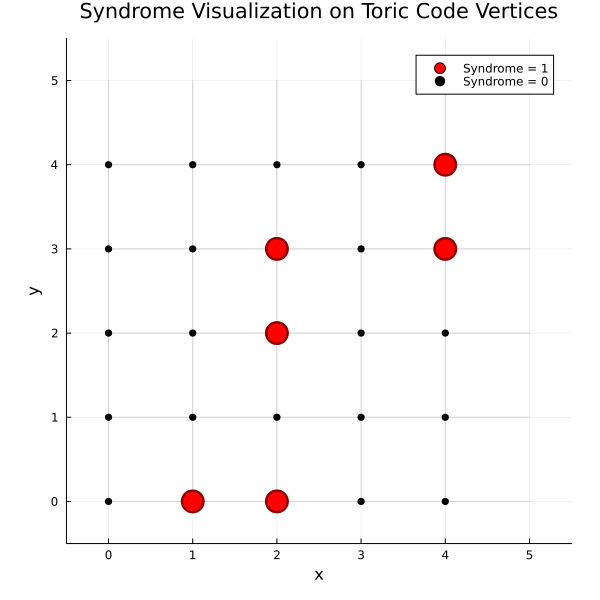

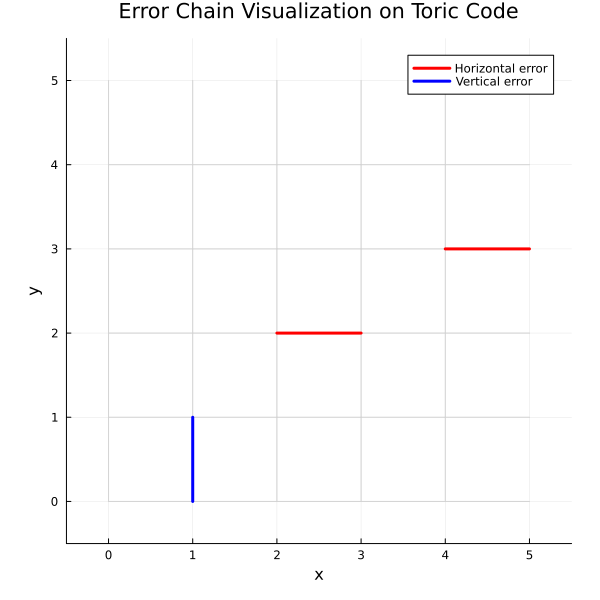

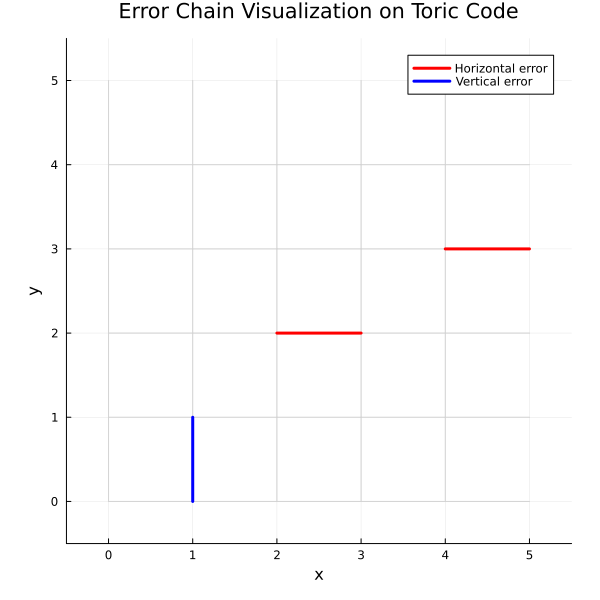

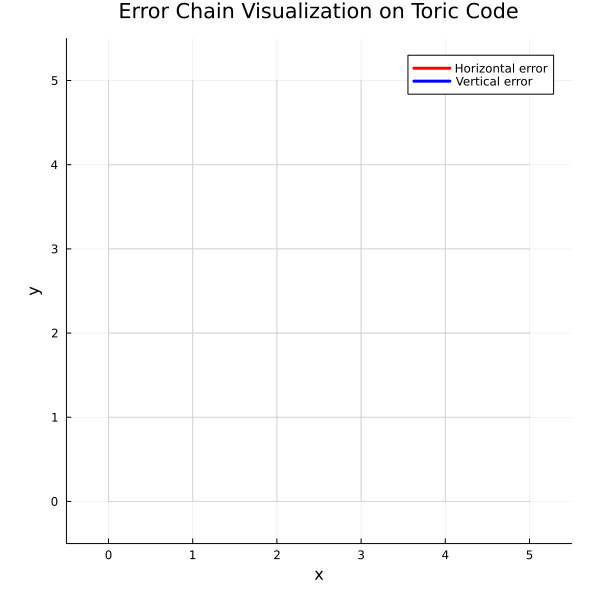

Syndrome vector: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
True errors: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded errors: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Residual: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [126]:
# Demonstration of visualization functions
println("Syndrome vector: ", syndrome)
println("True errors: ", errors_true)
println("Decoded errors: ", errors)
println("Residual: ", residual)

# Visualize the syndrome on plaquettes
syndrome_plot = visualize_syndrome(syndrome, L)
display(syndrome_plot)

# Visualize the true error chain
true_error_plot = visualize_error_chain((errors_true), L)
display(true_error_plot)

# Visualize the decoded error chain
decoded_error_plot = visualize_error_chain(errors, L)
display(decoded_error_plot)

# Visualize the residual error chain (difference between true and decoded)
residual_plot = visualize_error_chain(residual, L)
display(residual_plot)